# Neural Network on Cifar Datasets

Hello everyone and Professor Di Bo Ya. My name is Denzel Elden Wijaya, and in this notebook, I will demonstrate how to implement a Neural Network using the CIFAR dataset. Instead of using a built-in dataset loader, I will extract the raw data and create a custom dataset class that inherits from `torch.utils.data.Dataset`. This custom dataset will then be passed to `torch.utils.data.DataLoader` to enable efficient data loading during training.

The process will include these steps:
1. Load and Prepare the Dataset
2. Build the initial Neural Network Model
3. Tune the Model
4. Conclusion

## 1. Load and Prepare the Dataset

In [1]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CifarDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.class_to_idx = {}

        for idx, class_name in enumerate(sorted(os.listdir(root_dir))):
            class_path = os.path.join(root_dir, class_name)
            if os.path.isdir(class_path):
                self.class_to_idx[class_name] = idx
                for file_name in os.listdir(class_path):
                    if file_name.endswith((".png", ".jpg", ".jpeg")):
                        self.image_paths.append(os.path.join(class_path, file_name))
                        self.labels.append(idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = self.labels[index]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

In [2]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

train_dataset = CifarDataset(root_dir="/kaggle/input/cifar10-dataset/cifar10_train", transform=transform)
test_dataset = CifarDataset(root_dir="/kaggle/input/cifar10-dataset/cifar10_test", transform=transform)

cifar_train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
cifar_test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Total Training Data: {len(train_dataset)}")
print(f"Total Testing Data: {len(test_dataset)}")

Total Training Data: 50000
Total Testing Data: 10000


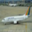

Label: airplane


In [3]:
# let's check the first image and its label

from IPython.display import display

image, label = train_dataset[0]
image = transforms.ToPILImage()(image)
display(image)

class_names = list(train_dataset.class_to_idx.keys())
label_name = class_names[label]

print(f"Label: {label_name}")


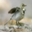

Label: bird


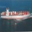

Label: ship


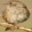

Label: bird


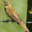

Label: bird


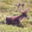

Label: deer


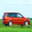

Label: automobile


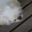

Label: dog


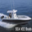

Label: ship


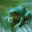

Label: frog


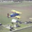

Label: airplane


In [4]:
# let's check the first 10 images and their labels

data_iter = iter(cifar_train_loader)
images, labels = next(data_iter)
for i in range(10):
    image = transforms.ToPILImage()(images[i])
    display(image)
    label_name = class_names[labels[i]]
    print(f"Label: {label_name}")


In [5]:
# Check the shape of the images and labels

print(f"Shape of images: {images.shape}")
print(f"Label batch: {labels}")

Shape of images: torch.Size([64, 3, 32, 32])
Label batch: tensor([2, 8, 2, 2, 4, 1, 5, 8, 6, 0, 9, 7, 4, 3, 3, 9, 9, 0, 8, 1, 6, 0, 2, 9,
        2, 5, 7, 3, 5, 9, 2, 1, 4, 6, 5, 2, 2, 2, 6, 1, 0, 4, 9, 2, 9, 8, 2, 4,
        3, 9, 1, 4, 0, 2, 4, 6, 8, 1, 5, 9, 0, 5, 0, 0])


We have successfully loaded the CIFAR dataset and implemented a custom dataset class. After ensuring that the dataset is properly processed, we've verified that the images and labels are correctly associated and displayed. The dataset is now ready for training.

## 2. Build the Initial Neural Network Model

With the dataset prepared, we will proceed to the second part of this task, which involves contructing the initial versioon of the model. In this phase, we will build a basic neural network architecture, focusing on the key components without applying any advanced optimizations or refinements. This initial model will serve as a baseline for later improvements.

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        
        self.__initialize_weights__()
        
    def __initialize_weights__(self):
        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)
                    
                    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

        
model = SimpleNN()

print(model.fc1.weight)

Parameter containing:
tensor([[-0.0354, -0.0151, -0.0164,  ..., -0.0339,  0.0402, -0.0243],
        [-0.0170,  0.0270,  0.0283,  ..., -0.0188, -0.0197,  0.0188],
        [ 0.0014, -0.0318,  0.0388,  ..., -0.0117, -0.0182, -0.0404],
        ...,
        [-0.0208,  0.0167, -0.0331,  ...,  0.0048,  0.0351,  0.0234],
        [-0.0328, -0.0036, -0.0159,  ..., -0.0394,  0.0221,  0.0244],
        [ 0.0323,  0.0345,  0.0132,  ..., -0.0383, -0.0209, -0.0102]],
       requires_grad=True)


In [7]:
device = torch.device('cuda')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

def train(model, train_loader, criterion, optimizer, epochs = 5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()

        accuracy = 100 * correct / total
        print(f"Epoch [{epoch + 1}/{epochs}] - Loss: {running_loss:.4f} - Accuracy: {accuracy:.2f}%")

train(model, cifar_train_loader, criterion, optimizer, epochs=5)

Epoch [1/5] - Loss: 1455.5786 - Accuracy: 33.57%
Epoch [2/5] - Loss: 1294.4436 - Accuracy: 40.94%
Epoch [3/5] - Loss: 1234.6952 - Accuracy: 43.39%
Epoch [4/5] - Loss: 1186.1363 - Accuracy: 45.82%
Epoch [5/5] - Loss: 1159.7326 - Accuracy: 47.09%


In [8]:
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

evaluate(model, cifar_test_loader)

Test Accuracy: 45.61%


Now that we have evaluated our initial model, which uses a simple Neural Network architecture and Xavier weight initialization, we achieved an accuracy of only **45.61%** on the testing set. 

To improve the model's performance, we will now apply several refinement techniques such as:
- Adding **Dropout layers** to reduce overfitting
- Tuning **batch size** and **number of epochs**
- Experimenting with different **learning rates** and **optimizer settings**

These adjustments will help us better understand how each factor influences the model’s ability to generalize.


## 3. Tune the Model

### Step-by-Step Model Refinement Plan

After evaluating the initial model, we will now gradually refine our neural network using the following steps:

1. **Wider the Model and Increasing Epoch**
   -  More neurons = More capacity to learn complex patterns in image data (adding layer and depth)
   -  Incresing epoch in some extent can help the machine learns better
  
2. **Adding Regularizations**
   - Penalize large weights to prevent extreme values

3. **Batch Normalizations** 
   - Normalize layer outputs to stabilize training

4. **Adding Dropout Layer** 
   - Randomly disable neurons to prevent co-adaptation (overfitting)

5. **Transition to CNN**
    - CNNs excel at spatial patterns in images

#### Step 1: Wider Model First

In [45]:
import torch.nn as nn

class WiderNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3*32*32, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 128)    
        self.fc4 = nn.Linear(128, 10)   
    
        self.__initialize_weights__()
    
    def __initialize_weights__(self):
        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return self.fc4(x)  # No softmax (included in CrossEntropyLoss)

In [46]:
model = WiderNN()
device = torch.device('cuda')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

train(model, cifar_train_loader, criterion, optimizer, epochs=10)

Epoch [1/10] - Loss: 1478.5893 - Accuracy: 31.47%
Epoch [2/10] - Loss: 1317.3665 - Accuracy: 39.38%
Epoch [3/10] - Loss: 1243.8024 - Accuracy: 42.99%
Epoch [4/10] - Loss: 1196.1730 - Accuracy: 45.11%
Epoch [5/10] - Loss: 1158.7659 - Accuracy: 46.90%
Epoch [6/10] - Loss: 1124.0562 - Accuracy: 48.54%
Epoch [7/10] - Loss: 1100.3315 - Accuracy: 49.54%
Epoch [8/10] - Loss: 1074.1911 - Accuracy: 50.72%
Epoch [9/10] - Loss: 1049.5730 - Accuracy: 52.16%
Epoch [10/10] - Loss: 1023.9396 - Accuracy: 53.09%


In [47]:
evaluate(model, cifar_test_loader)

Test Accuracy: 48.06%


In [44]:
import torch.nn as nn

class WiderNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3*32*32, 1024)
        self.fc2 = nn.Linear(1024, 256)   
        self.fc3 = nn.Linear(256, 10)   
    
        self.__initialize_weights__()
    
    def __initialize_weights__(self):
        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)  # No softmax (included in CrossEntropyLoss)

model = WiderNN()
device = torch.device('cuda')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

train(model, cifar_train_loader, criterion, optimizer, epochs=10)

evaluate(model, cifar_test_loader)

Epoch [1/10] - Loss: 1471.1822 - Accuracy: 32.63%
Epoch [2/10] - Loss: 1303.9041 - Accuracy: 40.51%
Epoch [3/10] - Loss: 1235.5686 - Accuracy: 43.68%
Epoch [4/10] - Loss: 1194.7099 - Accuracy: 45.57%
Epoch [5/10] - Loss: 1162.1605 - Accuracy: 47.10%
Epoch [6/10] - Loss: 1130.9000 - Accuracy: 48.45%
Epoch [7/10] - Loss: 1108.6801 - Accuracy: 49.37%
Epoch [8/10] - Loss: 1084.9758 - Accuracy: 50.62%
Epoch [9/10] - Loss: 1063.1674 - Accuracy: 51.66%
Epoch [10/10] - Loss: 1049.4077 - Accuracy: 52.11%
Test Accuracy: 51.04%


In [50]:
import torch.nn as nn

class WiderNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3*32*32, 512)
        self.fc2 = nn.Linear(512, 256)   
        self.fc3 = nn.Linear(256, 10)   
    
        self.__initialize_weights__()
    
    def __initialize_weights__(self):
        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)  # No softmax (included in CrossEntropyLoss)

model = WiderNN()
device = torch.device('cuda')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

train(model, cifar_train_loader, criterion, optimizer, epochs=10)

evaluate(model, cifar_test_loader)

Epoch [1/10] - Loss: 1459.0515 - Accuracy: 33.16%
Epoch [2/10] - Loss: 1300.5952 - Accuracy: 40.54%
Epoch [3/10] - Loss: 1236.2775 - Accuracy: 43.47%
Epoch [4/10] - Loss: 1190.0324 - Accuracy: 45.69%
Epoch [5/10] - Loss: 1153.8505 - Accuracy: 47.21%
Epoch [6/10] - Loss: 1130.6043 - Accuracy: 48.48%
Epoch [7/10] - Loss: 1107.2007 - Accuracy: 49.39%
Epoch [8/10] - Loss: 1089.4742 - Accuracy: 50.30%
Epoch [9/10] - Loss: 1065.9612 - Accuracy: 51.24%
Epoch [10/10] - Loss: 1046.5271 - Accuracy: 52.41%
Test Accuracy: 50.46%


**Result**

It is important to note that increasing the number of layers or neurons in a neural network does not always lead to better performance. In the experiments conducted, a four-layer network—when configured similarly to the three-layer model—actually resulted in poorer accuracy.

Additionally, modifying the number of neurons in a three-layer configuration showed that both too few and too many neurons can negatively impact performance. These findings highlight that model depth and width must be carefully balanced based on the data and training configuration.

After several trials, the most effective result was achieved using a three-layer model defined as WiderNN, which includes:

- 1024 neurons in the first hidden layer,

- 256 neurons in the second hidden layer,

- 10-unit output layer.

This model, trained using Xavier initialization and the Adam optimizer over 10 epochs, reached a test accuracy of 51%, which is a significant improvement over the baseline result of 46%. This outcome suggests that a wider architecture—when properly tuned—can lead to better generalization, even without increasing the depth of the network.

#### Step 2: Adding Regularizations and Batch Normalizations

In [10]:
import torch.nn as nn
import torch.nn.functional as F

class NormalizedNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3*32*32, 1024)
        self.bn1 = nn.BatchNorm1d(1024)  # BatchNorm after FC1
        self.fc2 = nn.Linear(1024, 256)
        self.bn2 = nn.BatchNorm1d(256)   # BatchNorm after FC2
        self.fc3 = nn.Linear(256, 10)
        
        self.__initialize_weights__()
    
    def __initialize_weights__(self):
        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        
        return self.fc3(x)

# Initialize with L2 regularization (weight decay)
model = NormalizedNN().to('cuda')
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # L2 penalty
criterion = nn.CrossEntropyLoss()

train(model, cifar_train_loader, criterion, optimizer, epochs=10)
evaluate(model, cifar_test_loader)

Epoch [1/10] - Loss: 1266.6492 - Accuracy: 42.16%
Epoch [2/10] - Loss: 1099.7229 - Accuracy: 49.83%
Epoch [3/10] - Loss: 1030.6368 - Accuracy: 53.10%
Epoch [4/10] - Loss: 981.4558 - Accuracy: 55.56%
Epoch [5/10] - Loss: 946.3150 - Accuracy: 56.89%
Epoch [6/10] - Loss: 909.4443 - Accuracy: 58.73%
Epoch [7/10] - Loss: 879.9884 - Accuracy: 59.92%
Epoch [8/10] - Loss: 849.6495 - Accuracy: 61.42%
Epoch [9/10] - Loss: 823.9593 - Accuracy: 62.54%
Epoch [10/10] - Loss: 791.4134 - Accuracy: 64.06%
Test Accuracy: 46.86%


In [11]:
import torch.nn as nn
import torch.nn.functional as F

class NormalizedNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3*32*32, 1024)
        self.bn1 = nn.BatchNorm1d(1024)  # BatchNorm after FC1
        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)   # BatchNorm after FC2
        self.fc3 = nn.Linear(512, 128)
        self.bn3 = nn.BatchNorm1d(128)   # BatchNorm after FC3
        self.fc4 = nn.Linear(128, 10)
        
        self.__initialize_weights__()
    
    def __initialize_weights__(self):
        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        
        x = self.fc3(x)
        x = self.bn3(x)
        x = F.relu(x)
        
        return self.fc4(x)

model = NormalizedNN().to('cuda')
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # L2 regularization
criterion = nn.CrossEntropyLoss()

train(model, cifar_train_loader, criterion, optimizer, epochs=10)
evaluate(model, cifar_test_loader)

Epoch [1/10] - Loss: 1265.1250 - Accuracy: 42.28%
Epoch [2/10] - Loss: 1104.8493 - Accuracy: 49.43%
Epoch [3/10] - Loss: 1037.5730 - Accuracy: 52.55%
Epoch [4/10] - Loss: 988.7477 - Accuracy: 54.69%
Epoch [5/10] - Loss: 945.9653 - Accuracy: 56.88%
Epoch [6/10] - Loss: 909.9340 - Accuracy: 58.76%
Epoch [7/10] - Loss: 878.4963 - Accuracy: 60.05%
Epoch [8/10] - Loss: 847.1903 - Accuracy: 61.47%
Epoch [9/10] - Loss: 811.4753 - Accuracy: 63.14%
Epoch [10/10] - Loss: 779.4842 - Accuracy: 64.65%
Test Accuracy: 53.94%


#### Step 3: Add Dropout Layers

Now, we see that more layers, will give better result since we are doing the normalizations and regularizations properly. But you will see the testing result is not that proper, we may put some dropout layers to prevent overfitting, which is happening in previous training. 

In [26]:
class NormalizedNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3*32*32, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.drop1 = nn.Dropout(0.25)
        
        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.drop2 = nn.Dropout(0.15)
        
        self.fc3 = nn.Linear(512, 128)
        self.bn3 = nn.BatchNorm1d(128)
        
        self.fc4 = nn.Linear(128, 10)

        self.__initialize_weights__()

    def __initialize_weights__(self):
        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.drop1(x)
        
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.drop2(x)
        
        x = F.relu(self.bn3(self.fc3(x)))
        return self.fc4(x)

model = NormalizedNN().to('cuda')
optimizer = optim.AdamW(model.parameters(), lr=0.0008,
                     weight_decay=5e-5)
criterion = nn.CrossEntropyLoss()

train(model, cifar_train_loader, criterion, optimizer, epochs=15)
evaluate(model, cifar_test_loader)

Epoch [1/15] - Loss: 1307.1127 - Accuracy: 40.30%
Epoch [2/15] - Loss: 1147.7510 - Accuracy: 47.63%
Epoch [3/15] - Loss: 1078.3876 - Accuracy: 50.96%
Epoch [4/15] - Loss: 1024.2862 - Accuracy: 53.19%
Epoch [5/15] - Loss: 980.1110 - Accuracy: 55.38%
Epoch [6/15] - Loss: 941.5788 - Accuracy: 57.06%
Epoch [7/15] - Loss: 904.3092 - Accuracy: 58.82%
Epoch [8/15] - Loss: 876.2708 - Accuracy: 60.08%
Epoch [9/15] - Loss: 842.5606 - Accuracy: 61.88%
Epoch [10/15] - Loss: 809.6519 - Accuracy: 63.24%
Epoch [11/15] - Loss: 779.6401 - Accuracy: 64.50%
Epoch [12/15] - Loss: 751.7934 - Accuracy: 65.65%
Epoch [13/15] - Loss: 726.1812 - Accuracy: 67.05%
Epoch [14/15] - Loss: 694.2351 - Accuracy: 68.45%
Epoch [15/15] - Loss: 666.4591 - Accuracy: 69.64%
Test Accuracy: 55.89%


In [27]:
class FCNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3*32*32, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.drop1 = nn.Dropout(0.3)
        
        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.drop2 = nn.Dropout(0.2)
        
        self.fc3 = nn.Linear(512, 128)
        self.bn3 = nn.BatchNorm1d(128)
        
        self.fc4 = nn.Linear(128, 10)

        self.__initialize_weights__()

    def __initialize_weights__(self):
        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.drop1(x)
        
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.drop2(x)
        
        x = F.relu(self.bn3(self.fc3(x)))
        return self.fc4(x)

model = FCNModel().to('cuda')
optimizer = optim.AdamW(model.parameters(), lr=0.0008,
                     weight_decay=5e-5)
criterion = nn.CrossEntropyLoss()

train(model, cifar_train_loader, criterion, optimizer, epochs=15)
evaluate(model, cifar_test_loader)

Epoch [1/15] - Loss: 1320.4592 - Accuracy: 39.52%
Epoch [2/15] - Loss: 1164.5300 - Accuracy: 47.06%
Epoch [3/15] - Loss: 1093.7390 - Accuracy: 50.10%
Epoch [4/15] - Loss: 1045.9785 - Accuracy: 52.44%
Epoch [5/15] - Loss: 1009.3111 - Accuracy: 53.96%
Epoch [6/15] - Loss: 968.8501 - Accuracy: 55.98%
Epoch [7/15] - Loss: 940.2675 - Accuracy: 57.44%
Epoch [8/15] - Loss: 908.8703 - Accuracy: 58.47%
Epoch [9/15] - Loss: 881.2774 - Accuracy: 59.78%
Epoch [10/15] - Loss: 852.4214 - Accuracy: 61.17%
Epoch [11/15] - Loss: 828.6302 - Accuracy: 62.13%
Epoch [12/15] - Loss: 800.4585 - Accuracy: 63.49%
Epoch [13/15] - Loss: 779.8859 - Accuracy: 64.52%
Epoch [14/15] - Loss: 750.4859 - Accuracy: 65.82%
Epoch [15/15] - Loss: 728.2759 - Accuracy: 66.75%
Test Accuracy: 57.38%


In [28]:
class FCNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3*32*32, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.drop1 = nn.Dropout(0.4)
        
        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.drop2 = nn.Dropout(0.3)
        
        self.fc3 = nn.Linear(512, 128)
        self.bn3 = nn.BatchNorm1d(128)
        
        self.fc4 = nn.Linear(128, 10)

        self.__initialize_weights__()

    def __initialize_weights__(self):
        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.drop1(x)
        
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.drop2(x)
        
        x = F.relu(self.bn3(self.fc3(x)))
        return self.fc4(x)

model = FCNModel().to('cuda')
optimizer = optim.AdamW(model.parameters(), lr=0.0008,
                     weight_decay=5e-5)
criterion = nn.CrossEntropyLoss()

train(model, cifar_train_loader, criterion, optimizer, epochs=15)
evaluate(model, cifar_test_loader)

Epoch [1/15] - Loss: 1355.5544 - Accuracy: 38.26%
Epoch [2/15] - Loss: 1197.5632 - Accuracy: 45.37%
Epoch [3/15] - Loss: 1134.1146 - Accuracy: 48.40%
Epoch [4/15] - Loss: 1090.0538 - Accuracy: 50.27%
Epoch [5/15] - Loss: 1055.2285 - Accuracy: 51.55%
Epoch [6/15] - Loss: 1024.8940 - Accuracy: 53.34%
Epoch [7/15] - Loss: 999.8150 - Accuracy: 54.52%
Epoch [8/15] - Loss: 970.3100 - Accuracy: 55.75%
Epoch [9/15] - Loss: 947.0821 - Accuracy: 56.56%
Epoch [10/15] - Loss: 925.5083 - Accuracy: 57.84%
Epoch [11/15] - Loss: 900.3910 - Accuracy: 59.21%
Epoch [12/15] - Loss: 884.0985 - Accuracy: 59.67%
Epoch [13/15] - Loss: 864.0871 - Accuracy: 60.48%
Epoch [14/15] - Loss: 845.5849 - Accuracy: 61.62%
Epoch [15/15] - Loss: 823.9721 - Accuracy: 62.28%
Test Accuracy: 57.12%


We actually have found out our FCNModel on the above, while we gained 57.12% accuracy only. MLPs struggle with CIFAR-10 (max ~60% accuracy) because they flatten RGB images, destroying crucial spatial relationships between pixels - unlike MNIST, where simple grayscale digit patterns are easily learned (90%+ accuracy). The 60% benchmark represents MLP's fundamental limitation with complex image data, as they lack convolutional layers' ability to detect local features like edges and textures. While CNNs naturally preserve 2D structure through filters and pooling to achieve 80-95% accuracy, MLPs force-learn pixel correlations through brute-force connections. Our result is strong for an MLP, proving the model extracted some meaningful patterns despite its architectural handicap. This gap demonstrates why CNNs dominate computer vision - they're biologically inspired to process hierarchical visual features that MLPs mathematically can't capture efficiently. The 60% ceiling should motivate to try out the CNN architecture, in hoping we can achieve the best result later.

#### Step 4 (BONUS) : Adding Convolutional Layer and Adding Learning Rate Scheduler

The 57.38% test accuracy ceiling with our MLP reveals a fundamental limitation: fully connected networks cannot effectively process spatial hierarchies in image data. While MLPs treat pixels as independent features (destroying local relationships), CNNs preserve 2D structure through:

1. Convolutional Layers:
    - Detect local patterns (edges, textures) via learnable filters
    - Share weights across spatial locations (parameter efficiency)

2. Hierarchical Feature Learning
    - Stacked conv layers build complex features from simple primitives
    - This architectural advantage allows CNNs to achieve >80% accuracy on CIFAR-10 where MLPs plateau at ~60%.

**Learning Rate Synergy**
We simultaneously optimize the LR because:
1. CNNs tolerate 1-10× higher LRs (0.001-0.01) than MLPs due to stabler gradients from:
    - Weight sharing in conv layers
    - Local connectivity patterns
2. Techniques like OneCycleLR exploit this to accelerate convergence

In [34]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.5)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(self.dropout(x))) 
        return self.fc2(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(cifar_train_loader), epochs=20)

def train(model, loader, criterion, optimizer, scheduler, epochs):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            optimizer.step()
            scheduler.step()
            
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            running_loss += loss.item()
        
        train_acc = 100. * correct / total
        print(f'Epoch {epoch+1}/{epochs} | Loss: {running_loss/len(loader):.4f} | Acc: {train_acc:.2f}% | LR: {scheduler.get_last_lr()[0]:.6f}')

def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    test_acc = 100. * correct / total
    print(f'Test Accuracy: {test_acc:.2f}%')
    return test_acc

train(model, cifar_train_loader, criterion, optimizer, scheduler, epochs=20)
best_acc = evaluate(model, cifar_test_loader)

Epoch 1/20 | Loss: 1.3967 | Acc: 50.80% | LR: 0.001043
Epoch 2/20 | Loss: 1.0730 | Acc: 62.00% | LR: 0.002801
Epoch 3/20 | Loss: 0.9892 | Acc: 65.73% | LR: 0.005202
Epoch 4/20 | Loss: 0.9474 | Acc: 67.47% | LR: 0.007602
Epoch 5/20 | Loss: 0.9069 | Acc: 69.50% | LR: 0.009358
Epoch 6/20 | Loss: 0.8530 | Acc: 71.44% | LR: 0.010000
Epoch 7/20 | Loss: 0.7919 | Acc: 73.44% | LR: 0.009874
Epoch 8/20 | Loss: 0.7362 | Acc: 75.30% | LR: 0.009504
Epoch 9/20 | Loss: 0.6775 | Acc: 77.36% | LR: 0.008908
Epoch 10/20 | Loss: 0.6160 | Acc: 79.34% | LR: 0.008116
Epoch 11/20 | Loss: 0.5672 | Acc: 81.05% | LR: 0.007168
Epoch 12/20 | Loss: 0.5048 | Acc: 83.04% | LR: 0.006111
Epoch 13/20 | Loss: 0.4476 | Acc: 84.92% | LR: 0.004999
Epoch 14/20 | Loss: 0.3808 | Acc: 87.03% | LR: 0.003886
Epoch 15/20 | Loss: 0.3292 | Acc: 88.61% | LR: 0.002829
Epoch 16/20 | Loss: 0.2776 | Acc: 90.55% | LR: 0.001881
Epoch 17/20 | Loss: 0.2353 | Acc: 91.89% | LR: 0.001090
Epoch 18/20 | Loss: 0.2052 | Acc: 92.81% | LR: 0.000495
E

Using this model, we can gain 83% accuracy on the testing period which is a nice and decent number.

## 4. Result

In this project, various strategies were applied to improve the performance of a neural network for image classification tasks. The following key points summarize the effects of each approach:

1. Adding Depth and Width: Increasing the depth (adding more layers) and width (increasing the number of neurons in each layer) provided a slight improvement in performance, but it also introduced challenges like overfitting. Specifically, while training accuracy increased, the testing accuracy did not improve proportionally. This suggests that while a larger network can capture more complex patterns, it may also become more prone to overfitting if not properly regularized. While, increasing the number of epochs will be also helping to increase the testing accuracy value, but at some extent it will not give significant impact on the testing accuracy. Hence, it will be better if you find out the best epoch for your model.

2. Regularization: Adding regularization techniques, such as L2 regularization (weight decay), helped reduce overfitting by penalizing large weights, encouraging the model to learn simpler, more generalizable patterns. Regularization proved essential in achieving a better balance between training and testing accuracy, stabilizing the model's performance.

3. Batch Normalization: Batch normalization significantly improved training stability by normalizing the activations within each layer, allowing the network to train faster and more reliably. It reduced the sensitivity to weight initialization, enabled higher learning rates, and led to more consistent results. It also helped in improving the model's ability to generalize.

4. Learning Rate Adjustments: Modifying the learning rate played a crucial role in the model's training efficiency. A learning rate of 0.01 was found to be effective for the CNN Model, while learning rate of 0.001 proved to be better on the MLP Model. Eventhough we know that smaller learning slowed down the learning process and larger rates led to instability and poor convergence. But once again, it also depends on the model.

5. Why Use CNN for Image Data?: Convolutional Neural Networks (CNNs) are designed to excel at image data by leveraging their ability to capture spatial hierarchies in images. Unlike fully connected networks, CNNs automatically learn the spatial features of images through convolutions, making them far more efficient and accurate for image classification tasks. Using CNNs drastically improved the model’s performance compared to fully connected architectures, particularly in capturing local patterns and reducing the number of parameters.

That will be the end of this packed notebook. I hope you guys get the essential on exploring which model is suitable with your dataset, since each dataset has it s own uniquness and features. Thank you for reading until the end.